In [ ]:
yellow_tripdata = pd.read_csv('clean_yellow_2022-06.csv')
fhvhv_tripdata = pd.read_csv('clean_fhvhv_2022-06.csv')
green_tripdata = ppd.read_csv('clean_green_2022-06.csv')
# Seleccionar características relevantes
#yellow_tripdata = yellow_tripdata[['passenger_count', 'trip_distance', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']]
#green_tripdata = green_tripdata[['passenger_count', 'trip_distance', 'lpep_pickup_datetime', 'lpep_dropoff_datetime']]

# Unir los DataFrames relevantes
merged_data = pd.concat([yellow_tripdata, fhvhv_tripdata, green_tripdata], ignore_index=True)


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Supongamos que tu DataFrame tiene las características y la variable objetivo
yellow_tripdata = pd.read_csv('clean_yellow_2022-06.csv')
fhvhv_tripdata = pd.read_csv('clean_fhvhv_2022-06.csv')
green_tripdata = pd.read_csv('clean_green_2022-06.csv')

# Unir los DataFrames relevantes
merged_data = pd.concat([yellow_tripdata, fhvhv_tripdata, green_tripdata], ignore_index=True)
def get_relation(amount, distance):
    if distance == 0:
        relation = amount
    else:
        relation = amount / distance
    return relation

df= merged_data
# Aplicar la transformación
df['rel_amount_dist'] = df.apply(lambda f: get_relation(f['total_amount'],f['trip_distance']), axis=1)
umbral = 4.52
etiquetas = ['Y', 'N']
# Aplicar la transformación
df['Discount'] = pd.cut(df['rel_amount_dist'], bins=[-float('inf'), umbral, float('inf')], labels=etiquetas)
df.head()


,PULocationID,DOLocationID,trip_distance,total_amount,passenger_count,year,month,day,pu_time,do_time,trip_time,type_service,rel_amount_dist,Discount
0,132,150,14.02,44.05,1.0,2022,6,15,17:51,18:23,1949,0,3.141940,Y
1,141,143,2.70,20.75,2.0,2022,6,19,15:11,15:31,1195,0,7.685185,N
2,142,239,0.60,9.95,3.0,2022,6,16,19:55,19:58,184,0,16.583333,N
3,231,80,6.83,25.88,1.0,2022,6,2,23:27,23:55,1680,0,3.789165,Y
4,263,166,3.60,22.55,1.0,2022,6,7,10:16,10:36,1217,0,6.263889,N


In [39]:
44.05/14.02

3.141940085592011

In [45]:
df.describe()

,PULocationID,DOLocationID,trip_distance,total_amount,passenger_count,year,month,day,trip_time,type_service,rel_amount_dist,Discount
count,212400.000000,212400.000000,212400.000000,212400.000000,212400.000000,212400.000000,212400.000000,212400.000000,2.124000e+05,212400.000000,212400.000000,212400.000000
mean,141.916794,146.001040,10.638038,24.429395,1.072387,2021.999275,6.000165,15.375056,9.946824e+03,0.800377,8.152818,0.250579
std,74.197532,76.962546,888.156571,33.310064,0.443738,0.118764,0.026486,8.571766,2.327524e+06,0.399718,74.088113,0.433348
min,1.000000,1.000000,0.000000,-484.300000,0.000000,2002.000000,6.000000,1.000000,-4.200000e+01,0.000000,-5855.000000,0.000000
25%,77.000000,79.000000,1.530000,11.930000,1.000000,2022.000000,6.000000,8.000000,5.830000e+02,1.000000,4.515789,0.000000
50%,142.000000,145.000000,2.830000,18.360000,1.000000,2022.000000,6.000000,15.000000,9.380000e+02,1.000000,6.104306,0.000000
75%,214.000000,225.000000,5.929250,29.520000,1.000000,2022.000000,6.000000,23.000000,1.486000e+03,1.000000,8.416302,1.000000
max,265.000000,265.000000,269277.460000,6996.100000,6.000000,2022.000000,12.000000,31.000000,6.193204e+08,1.000000,16896.000000,1.000000


Estamos tomando la relacion entre el costo y la distancia (esto seria el costo por milla) para evaluar la distribucion de esta variable teniendo en cuenta que los valores mas altos de esta variable corresponderian a los viajes en los que hay mayor cantidad de transito, mientras que los valores menores corresponderian a los momentos en los que hay menor cantidad de transito. Para esto analizamos la distribucion con el siguiente histograma, y la descripcion a partir de la media, el desvio standar y los valores de los cuartiles.

### HISTOGRAMA

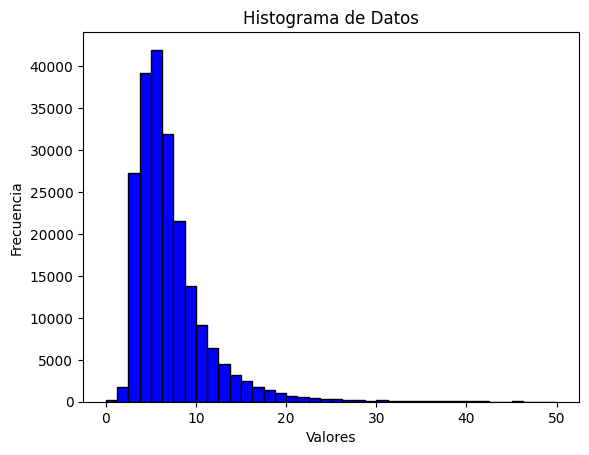

In [35]:
import matplotlib.pyplot as plt

# Datos que deseas representar en el histograma
data =  df['rel_amount_dist']

# Crear el histograma
plt.hist(data, bins=40, color='blue', edgecolor='black', range=(0,50))

# Personalizar el histograma (opcional)
plt.title('Histograma de Datos')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()


Definimos tomar como valor umbral para la clasificacion de los viajes con y sin descuento al valor limite del primer cuartil. De esta forma el 25% de los viajes con menor costo por milla tendrian la clasificacion "Y" (positiva para el descuento) para esto viajes ofrecerles un menor costo, incentivando la movilidad en los horarios con menor congestion de transito. Por otro lado el 75% de los viajes quedara con la clasificacion "N" (negativa para el descuento) a la cual no se le afectara el monto de la tarifa. Teniendo en cuenta esta columna, como nuestra variable objetivo, vamos a entrenar distintos modelos de machine Learning:
 - Regresion Logistica
 - K vecinos
 - Arbol de decision
Con el fin de ver cual es el modelo optimo para predecir a que viajes se le aplicaran descuentos, teniendo en cuenta como caracteristicas las variables distancia('trip_distance'), dia(day) y tiempo de viaje('trip_time').

Por ultimo vamos a priorizar el modelo que de menor valor de falsos positivos (recall), ya que nos intera la viabilidad econoica de la empresa, considerando que esta en sus inicios.

In [38]:
# Las características se almacenan en X y la variable objetivo en y
y=  df['Discount']#--> v objetivo
X= df[['trip_distance', 'day','trip_time']]
# División de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creación del modelo de Regresión Logística
model = LogisticRegression()

# Entrenamiento del modelo en el conjunto de entrenamiento
model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')



Accuracy: 0.2547080979284369
Confusion Matrix:
[[    6 31658]
 [    2 10814]]
Classification Report:
              precision    recall  f1-score   support

           N       0.75      0.00      0.00     31664
           Y       0.25      1.00      0.41     10816

    accuracy                           0.25     42480
   macro avg       0.50      0.50      0.20     42480
weighted avg       0.62      0.25      0.10     42480



In summary, our model has difficulty predicting the "N" class and performs reasonably well on the "Y" class. You may need to adjust or improve your model, especially if you are interested in predicting the "N" class.

In [40]:
df.shape

(212400, 14)

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cargar tus datos en un DataFrame, asegurándote de que las características y la columna de clasificación estén en su lugar
# Por ejemplo, asumiendo que ya tienes los datos cargados y preprocesados en 'data'

# Las características se almacenan en X y la variable objetivo en y
y=  df['Discount']#--> v objetivo
X= df[['trip_distance', 'day','trip_time']]


# Codificar la variable categórica 'classification' en valores numéricos
label_encoder = LabelEncoder()
df['Discount'] = label_encoder.fit_transform(df['Discount'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df[['trip_distance', 'day','trip_time']] # Características
y = df['Discount']  # Etiquetas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo KNN
k = 2  # Valor de k (número de vecinos)
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')


Accuracy: 0.8407956685499058
Confusion Matrix:
[[30348  1316]
 [ 5447  5369]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     31664
           1       0.80      0.50      0.61     10816

    accuracy                           0.84     42480
   macro avg       0.83      0.73      0.76     42480
weighted avg       0.84      0.84      0.83     42480



In conclution, this model performs significantly better than the previous model. It has high accuracy, strong performance in predicting class "0" (high precision, recall, and F1-score), and reasonable performance in predicting class "1."

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cargar tus datos en un DataFrame, asegurándote de que las características y la columna de clasificación estén en su lugar
# Por ejemplo, asumiendo que ya tienes los datos cargados y preprocesados en 'data'

# Las características se almacenan en X y la variable objetivo en y
#y=  df['Discount']#--> v objetivo
#X= df[['trip_distance', 'day','trip_time']]


# Codificar la variable categórica 'classification' en valores numéricos
label_encoder = LabelEncoder()
df['Discount'] = label_encoder.fit_transform(df['Discount'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df[['trip_distance', 'day','trip_time']] # Características
y = df['Discount']  # Etiquetas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo KNN
k = 3  # Valor de k (número de vecinos)
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')


Accuracy: 0.8656073446327683
Confusion Matrix:
[[29314  2350]
 [ 3359  7457]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     31664
           1       0.76      0.69      0.72     10816

    accuracy                           0.87     42480
   macro avg       0.83      0.81      0.82     42480
weighted avg       0.86      0.87      0.86     42480



In summary, this model also performs well, with a high accuracy and strong performance in predicting class "0," and reasonably good performance in predicting class "1." The reason is the new number of K, here K is 3, while in the previuos model it was 2. As it has a better recall for both, negative and positive results, this is a stronger model for our case.

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cargar tus datos en un DataFrame, asegurándote de que las características y la columna de clasificación estén en su lugar
# Por ejemplo, asumiendo que ya tienes los datos cargados y preprocesados en 'data'

# Codificar la variable categórica 'classification' en valores numéricos
label_encoder = LabelEncoder()
df['Discount'] = label_encoder.fit_transform(df['Discount'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df[['trip_distance', 'day','trip_time']] # Características
y = df['Discount']  # Etiquetas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de Árboles de Decisión
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')


Accuracy: 0.8422080979284369
Confusion Matrix:
[[28369  3295]
 [ 3408  7408]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     31664
           1       0.69      0.68      0.69     10816

    accuracy                           0.84     42480
   macro avg       0.79      0.79      0.79     42480
weighted avg       0.84      0.84      0.84     42480



In summary, this model performs reasonably well with a good accuracy. It has strong performance in predicting class "0" and moderate performance in predicting class "1.". Howerver, this model has a good presition at predicting true positivies and avoiding false positivies, the previuos model has an overall better performance in every metric.